In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
Seed = 42
np.random.seed(42)

## Load the Data

In [3]:
p = Preprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = Preprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [4]:
print(x_train.shape)
print(x_test.shape)


(225000, 31)
(25000, 31)


## Logistic predictions from weights

In [5]:
def predict(weight, x_test,boundary =0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = sigmoid(x_test.dot(weight))
    
    f = lambda x : 0 if x <boundary else 1
    
    predictions = np.array([ f(x) for x in pred])
    
    return predictions

## Cross Validation, Calculation of the Accuracy 

In [6]:
def K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, _lambda, gamma, batch_size):
    """
    #K_Cross_Validation training technique
    
    :param xt_training: extended feature matrix 
    :type xt: numpy 2D array
    
    :param y_training: labels
    :type y_training: 1D array
    
    :param K: number of folds
    :type K: int
    
    :param initial_w: initial value of weights
    :type initial_w: numpy 1D array
    
    :param max_iters: the number of maximal iterations
    :type max_iters: int
    
    :param _lambda: regularizer
    :type _lambda: float64
    
    :param gamma: learning rate
    :type gamma: float64
    
    :param batch_size: size of the batch for batch_reg_logistic_regression
    :type batch_size: int
    
    :return: accuracy, validation_weights, accuracy_mean, weights_mean
    :rtype:  1D numpy array,  (K,xt_training.shape[1])numpy array,  float64, 1D numpy array
    
    """

    #Initialization of all needed arrays
    validation_loss = np.zeros(K)
    validation_weights = np.zeros((K,xt_training.shape[1]))
    accuracy = np.zeros(K)
    indices = np.linspace(0, len(y_training)-1 , K+1 ,dtype=int) #no need to randomize, split of test/train shuffled the data
    
    for i in range(K):
        #Split de data 
        x_cross_test = xt_training[indices[i] : indices[i+1], :]
        y_cross_test = y_training[indices[i] : indices[i+1]]
        x_cross_train = np.concatenate((xt_training[:indices[i], :], xt_training[indices[i]:, :]),axis=0)
        y_cross_train = np.concatenate((y_training[:indices[i]], y_training[indices[i]:]),axis=0)
        
        #Run Reg_Logistric_Regression on the obtained datasets
        validation_weights[i], validation_loss[i] = logistic_regression(y_cross_train, x_cross_train, initial_w, max_iters, gamma)
        #Calculate predictions of the model
        predictions = predict(validation_weights[i] , x_cross_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_cross_test) / len(y_cross_test)
        
    return accuracy, validation_weights, np.mean(accuracy), np.mean(validation_weights, axis=0)
        

C:\Users\thoma\School\Machine_learning\ML-Project1\helpers\implementation_helpers.py:89: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


0.735358808440869


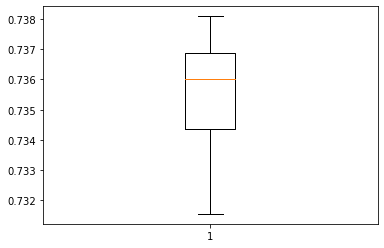

In [35]:
acc, weights, mean_acc, mean_weights= K_Cross_Validation(x_train, y_train, 10, np.zeros(x_train.shape[1]), 20, 0, 0.003, 100)
print(mean_acc)
plt.boxplot(acc)
plt.show()

## Trying to tune the gamma parameter

[1.00000000e-07 3.59381366e-07 1.29154967e-06 4.64158883e-06
 1.66810054e-05 5.99484250e-05 2.15443469e-04 7.74263683e-04
 2.78255940e-03 1.00000000e-02]
4.641588833612782e-06 0.7455410805672225


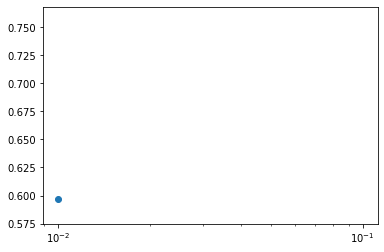

In [10]:
def Tune_Gamma(xt_training, y_training, K, gamma_range, initial_w, max_iters, batch_size=None):
        
    gammas = np.logspace(-7, gamma_range, 10)
    print(gammas)
    max_acc = 0
    opt_lambda = 0
    accuracies = []
    for i, gamma in enumerate(gammas):
       
        accuracy = K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, None, gamma, None)[2]
        accuracies.append([gamma,accuracy])
        if (accuracy > max_acc):
            max_acc = accuracy
            opt_gamma = gamma
                
    return opt_gamma , max_acc, np.array(accuracies)
opt_gamma, max_acc, accuracies = Tune_Gamma(xt_training=x_train, y_training=y_train, K= 5, gamma_range=-2, initial_w=np.zeros(x_train.shape[1]), max_iters= 50)
accuracies = np.array(accuracies)
print(opt_gamma, max_acc)

Text(0, 0.5, 'accuracy')

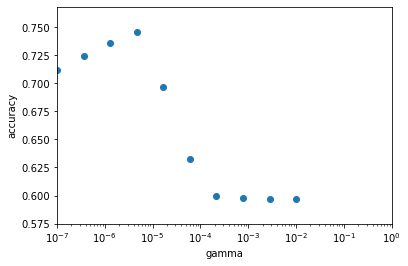

In [37]:
plt.scatter(accuracies[:,0],accuracies[:,1])
plt.xscale('log')
plt.xlim(10**(-7),1)
plt.xlabel("gamma")
plt.ylabel('accuracy')

## Train on full trainset with optimal Hyperparemeters 

Text(0, 0.5, 'loss')

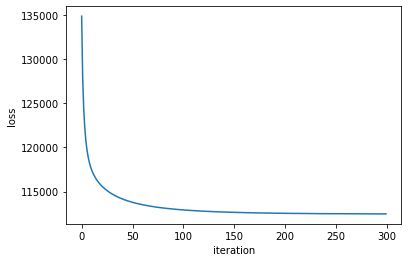

In [38]:
opt_w, losses = logistic_regression(y_train, x_train, np.zeros(x_train.shape[1]), 300, opt_gamma, all_losses=True)
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel('loss')

In [27]:
opt_w

array([-8.90930357e-01,  4.38261487e-02, -6.81745136e-01, -1.06417996e+00,
        3.31155081e-01, -2.99868781e-02,  4.13515510e-01,  5.04133748e-02,
        1.06710045e+00, -9.02557656e-02,  1.54740874e-01, -7.41663600e-01,
        2.47186525e-01,  2.19279872e-01,  4.85751650e-01,  1.09939073e-03,
       -1.60322654e-03,  9.58775734e-01, -5.26613470e-03,  3.93204754e-03,
        1.42481268e-01,  4.71501476e-04, -1.38008098e-01,  1.12900442e-01,
       -1.64795824e-01,  6.53037962e-04, -2.19558272e-03, -1.58455306e-01,
        3.56978604e-03, -5.27473709e-04, -1.44193030e-01])

## Evaluate performance on the testset

In [28]:
p = predict(opt_w, x_test)
print(f"accuracy={(p==y_test).mean()}")


accuracy=0.753


In [33]:
for b in [0.3,0.4,0.5,0.55,0.6,0.65,0.7]:
    p = predict(opt_w,x_test,b)
    print(f"decision boundary={b}")
    print(f"confusion matrix: \n {confusion_matrix(y_test,p)}")
    print(f"accuracy={(p==y_test).mean()}")


decision boundary=0.3
test
confusion matrix: 
 [[0.66668697 0.33331303]
 [0.17697775 0.82302225]]
accuracy=0.72036
decision boundary=0.4
test
confusion matrix: 
 [[0.77992325 0.22007675]
 [0.30443901 0.69556099]]
accuracy=0.75096
decision boundary=0.5
test
confusion matrix: 
 [[0.86684534 0.13315466]
 [0.46475591 0.53524409]]
accuracy=0.753
decision boundary=0.55
test
confusion matrix: 
 [[0.9013218  0.0986782 ]
 [0.54421531 0.45578469]]
accuracy=0.74836
decision boundary=0.6
test
confusion matrix: 
 [[0.92842785 0.07157215]
 [0.63684027 0.36315973]]
accuracy=0.73436
decision boundary=0.65
test
confusion matrix: 
 [[0.95120911 0.04879089]
 [0.72130957 0.27869043]]
accuracy=0.72032
decision boundary=0.7
test
confusion matrix: 
 [[0.9687519  0.0312481 ]
 [0.79144821 0.20855179]]
accuracy=0.70776


 test and train scores are ver close & the cross-scores are also close --> no overfitting

## Make prediction File for submission

In [ ]:
p = Preprocessing(load_csv('../dataset/test.csv'))
ids, tx = p.preprocess(labeled=False)


In [ ]:
p = predict(w,tx)


In [ ]:
ids.shape

In [ ]:
create_csv_submission(ids, p, "model_0001.csv")